In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
from data_reader import read_data
from node import get_node_data
import pandas as pd
import numpy as np

In [3]:
raw_data = read_data()
# nodes = {"pi"+str(i+2):i for i in range(4)}
nodes = ["pi2", "pi3", "pi4", "pi5"]

## Visualising Data

In [ ]:
data = {}
sample_sizes = []
for experiment in range(1,4):
    node_data, models, inliers = get_node_data(raw_data, experiment, return_models=True)
    min_samples = min([d.shape[0] for d in node_data])
    m = int(min_samples/2)
    sample_sizes.append(m)
    for i in range(4):
        node_data[i] = node_data[i].sample(m).reset_index(drop=True)
    data[experiment] = {"sampled_data" : node_data, "models" : models, "inliers" : inliers, "all_data" : node_data}

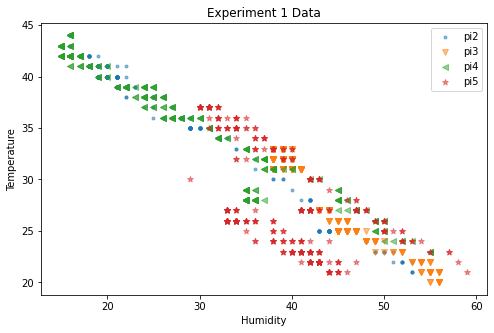

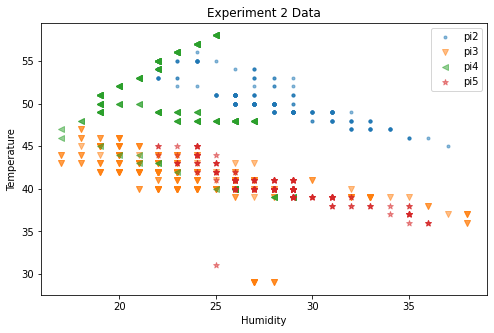

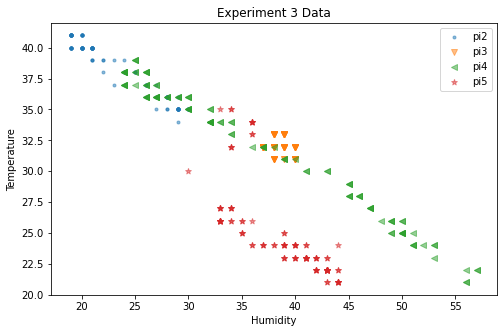

In [78]:
from visualising import visualise_experiment
visualise_experiment(data[1]["all_data"])
visualise_experiment(data[2]["all_data"])
visualise_experiment(data[3]["all_data"])

In [80]:
from sklearn.preprocessing import StandardScaler
def standardise_raw_data():
    std_data ={}
    for experiment in range(1,4):
        node_data = data[experiment]["all_data"]
        scaler = StandardScaler()
        experiment_std_data = [pd.DataFrame(columns = ["humidity", "temperature"],
                                          data = scaler.fit_transform(node_data[i][["humidity", "temperature"]])) 
                             for i in range(4)]
        for df in experiment_std_data:
            df["experiment"] = experiment
        std_data[experiment] = experiment_std_data
    return std_data
std_data = standardise_raw_data()

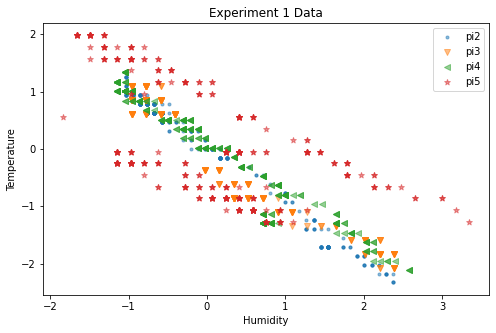

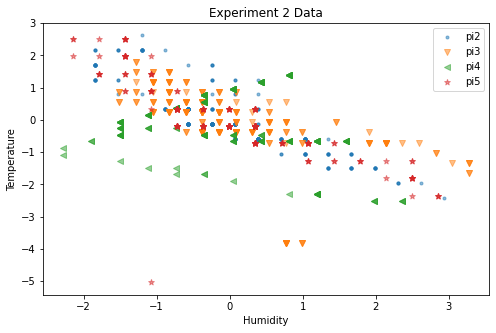

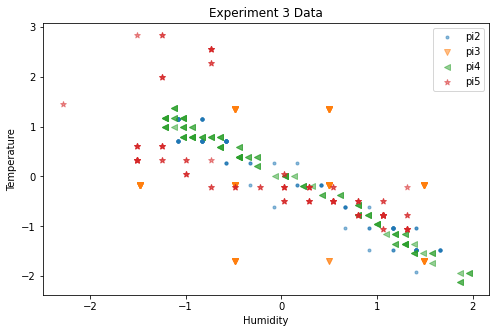

In [81]:
from visualising import visualise_experiment
visualise_experiment(std_data[1])
visualise_experiment(std_data[2])
visualise_experiment(std_data[3])

## Similarity MMD

In [52]:
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable

def bandwidth_experiment(samples, similar_nodes, other_nodes, bandwidths, kernel):
    print(kernel.upper(), "\n")
    t = PrettyTable(['Bandwidth', 'Similarity MMD', 'Dissimilarity MMD'])
    for bandwidth in bandwidths:
        avg_sim_mmd, avg_dis_mmd, s, d = ASDMMD(samples, similar_nodes, other_nodes, kernel, bandwidth)
        t.add_row([bandwidth, avg_sim_mmd, avg_dis_mmd])
        print(s)
        print(d)
        print()
        
    print(t)
    print()

### Experiment 1

Nodes pi2 and pi4 are similar according to mmd and nodes pi3 and pi5 are similar to each other but not to the others

In [62]:
from maximum_mean_discrepancy import get_tensor_samples
tensor_samples = get_tensor_samples(data[1]["sampled_data"], sample_size=sample_sizes[0])

In [63]:
similar_nodes = ["pi2","pi4"]
other_nodes = ["pi3","pi5"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(1, 10, 5), "rbf")

LINEAR 

+----------------+--------------------+
|     Nodes      |    Similar MMD     |
+----------------+--------------------+
| ('pi2', 'pi4') | 1.3750762939453125 |
+----------------+--------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi3', 'pi2') | 29.179397583007812 |
| ('pi3', 'pi4') | 35.089630126953125 |
| ('pi5', 'pi2') |  20.8682861328125  |
| ('pi5', 'pi4') | 25.835586547851562 |
| ('pi3', 'pi5') | 2.6141815185546875 |
+----------------+--------------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi4') | 4.1251220703125 |
+----------------+-----------------+
+----------------+------------------+
|     Nodes      |  Dissimilar MMD  |
+----------------+------------------+
| ('pi3', 'pi2') | 87.5382080078125 |
| ('pi3', 'pi4') | 105.268798828125 |
| ('pi5', 'pi2') | 62.6048583984375 |
| ('pi5', 'pi4') 

similar_sets = ["pi3", "pi5"]
dissimilar_sets = ["pi2", "pi4"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

In [64]:
tensor_samples = get_tensor_samples(std_data[1], sample_size=sample_sizes[0])

In [68]:
similar_nodes = ["pi2","pi3","pi4"]
other_nodes = ["pi5"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "rbf")

LINEAR 

+----------------+------------------------+
|     Nodes      |      Similar MMD       |
+----------------+------------------------+
| ('pi2', 'pi3') | 0.0011867765570059419  |
| ('pi2', 'pi4') | 2.189068982261233e-05  |
| ('pi3', 'pi4') | 0.0009323577396571636  |
| ('pi5', 'pi2') | 0.0006115565774962306  |
| ('pi5', 'pi3') | 0.00014020566595718265 |
| ('pi5', 'pi4') | 0.00041372491978108883 |
+----------------+------------------------+
+-------+----------------+
| Nodes | Dissimilar MMD |
+-------+----------------+
+-------+----------------+

+----------------+-----------------------+
|     Nodes      |      Similar MMD      |
+----------------+-----------------------+
| ('pi2', 'pi3') | 0.0035603316500782967 |
| ('pi2', 'pi4') | 6.567034142790362e-05 |
| ('pi3', 'pi4') |  0.002797073917463422 |
| ('pi5', 'pi2') | 0.0018346661236137152 |
| ('pi5', 'pi3') | 0.0004206171724945307 |
| ('pi5', 'pi4') |  0.001241173013113439 |
+----------------+-----------------------+
+-------+---

### Experiment 3

Nodes pi3, pi4, pi5 are dissimilar with pi2. Nodes pi3 and pi4 are similar to each other and similar to pi5.

In [69]:
tensor_samples = get_tensor_samples(data[3]["sampled_data"], sample_size=sample_sizes[2])

In [70]:
similar_nodes = ["pi2", "pi4"]
other_nodes = ["pi3", "pi5"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(1,5 , 4), "rbf")

LINEAR 

+----------------+--------------------+
|     Nodes      |    Similar MMD     |
+----------------+--------------------+
| ('pi2', 'pi4') | 28.566131591796875 |
| ('pi3', 'pi4') |  4.40692138671875  |
| ('pi5', 'pi4') | 9.591445922851562  |
| ('pi3', 'pi5') | 9.904647827148438  |
+----------------+--------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi3', 'pi2') | 31.458526611328125 |
| ('pi5', 'pi2') | 48.74272155761719  |
+----------------+--------------------+

+----------------+-------------------+
|     Nodes      |    Similar MMD    |
+----------------+-------------------+
| ('pi2', 'pi4') | 85.69854736328125 |
| ('pi3', 'pi4') |  13.220947265625  |
| ('pi5', 'pi4') | 28.77447509765625 |
| ('pi3', 'pi5') | 29.71405029296875 |
+----------------+-------------------+
+----------------+-------------------+
|     Nodes      |   Dissimilar MMD  |
+----------------+-------------------+
|

similar_sets = ["pi2", "pi3", "pi4"]
dissimilar_sets = ["pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

In [85]:
tensor_samples = get_tensor_samples(std_data[3], sample_size=sample_sizes[2])

In [86]:
similar_nodes = ["pi2", "pi4"]
other_nodes = ["pi3", "pi5"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(10, 50, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(1, 5 , 4), "rbf")

LINEAR 

+----------------+------------------------+
|     Nodes      |      Similar MMD       |
+----------------+------------------------+
| ('pi2', 'pi4') | -8.741480428398063e-08 |
| ('pi3', 'pi2') | -3.462572806256503e-07 |
| ('pi3', 'pi5') | -2.604793394311855e-07 |
+----------------+------------------------+
+----------------+-------------------------+
|     Nodes      |      Dissimilar MMD     |
+----------------+-------------------------+
| ('pi3', 'pi4') | -1.6092607779683021e-07 |
| ('pi5', 'pi2') |  1.464210299673141e-07  |
| ('pi5', 'pi4') |  -1.751254075088582e-08 |
+----------------+-------------------------+

+----------------+-------------------------+
|     Nodes      |       Similar MMD       |
+----------------+-------------------------+
| ('pi2', 'pi4') |  -8.975769674179901e-07 |
| ('pi3', 'pi2') | -1.4966715298214694e-06 |
+----------------+-------------------------+
+----------------+------------------------+
|     Nodes      |     Dissimilar MMD     |
+--------

### Experiment 2

In [25]:
tensor_samples = get_tensor_samples(data[2]["sampled_data"], sample_size=sample_sizes[1])

In [26]:
similar_nodes = ["pi3", "pi5"]
other_nodes = ["pi2", "pi4"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(5,100 , 5), "rbf")

LINEAR 

+----------------+-------------------+
|     Nodes      |    Similar MMD    |
+----------------+-------------------+
| ('pi3', 'pi5') | 4.380279541015625 |
+----------------+-------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi2', 'pi3') | 12.232162475585938 |
| ('pi2', 'pi5') | 11.631454467773438 |
| ('pi4', 'pi3') | 12.050918579101562 |
| ('pi4', 'pi5') | 16.890335083007812 |
| ('pi2', 'pi4') | 5.491302490234375  |
+----------------+--------------------+

+----------------+-------------------+
|     Nodes      |    Similar MMD    |
+----------------+-------------------+
| ('pi3', 'pi5') | 13.14080810546875 |
+----------------+-------------------+
+----------------+-------------------+
|     Nodes      |   Dissimilar MMD  |
+----------------+-------------------+
| ('pi2', 'pi3') | 36.69635009765625 |
| ('pi2', 'pi5') |   34.89404296875  |
| ('pi4', 'pi3') | 36.15289306640625 |
| ('pi

In [87]:
tensor_samples = get_tensor_samples(std_data[2], sample_size=sample_sizes[1])

In [92]:
similar_nodes = ["pi2", "pi3", "pi5"]
other_nodes = ["pi4"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.5, 2, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1,1 , 5), "rbf")

LINEAR 

+----------------+------------------------+
|     Nodes      |      Similar MMD       |
+----------------+------------------------+
| ('pi2', 'pi3') | 1.8753909536428637e-10 |
| ('pi2', 'pi5') | -3.545031490581607e-10 |
| ('pi3', 'pi5') | -4.715672852206865e-10 |
+----------------+------------------------+
+----------------+------------------------+
|     Nodes      |     Dissimilar MMD     |
+----------------+------------------------+
| ('pi4', 'pi2') | 2.2520056930375176e-09 |
| ('pi4', 'pi3') | 6.708955169187902e-09  |
| ('pi4', 'pi5') | 5.883830755948338e-09  |
+----------------+------------------------+

+----------------+------------------------+
|     Nodes      |      Similar MMD       |
+----------------+------------------------+
| ('pi2', 'pi3') | 3.7507819072857274e-10 |
| ('pi2', 'pi5') | -7.090062981163214e-10 |
| ('pi3', 'pi5') | -9.43134570441373e-10  |
+----------------+------------------------+
+----------------+------------------------+
|     Nodes      |    

## Testing Hypothesis

In [4]:
from modelling import grid_search_models, fit_clf, score_clf, select_model_data  
from similar import get_similar_pairs_nodes

def test_in_pairs(similar_pairs, model_data, models):
    l = []
    for pair in similar_pairs:
        x = model_data[pair[0]]
        y = model_data[pair[1]]
        
        model_x = models[pair[0]]
        ex = fit_clf(model_x, x)
        exy = score_clf(model_x, y)

        model_y = models[pair[1]]
        ey = fit_clf(model_y, y)
        eyx = score_clf(model_y, x)       
        
        l.append(pd.DataFrame([{"model_node" : pair[0], "test_node" : pair[1], "discrepancy" : round(abs(ex-exy),2)}]))
        l.append(pd.DataFrame([{"model_node" : pair[1], "test_node" : pair[0], "discrepancy" : round(abs(ey-eyx),2)}]))
    return pd.concat(l, ignore_index = True)

def test_hypothesis(clf_name, model_data, similar_pairs, similar_nodes): 
    models, models_df = grid_search_models(clf_name, model_data, similar_nodes)
    test_df = test_in_pairs(similar_pairs, model_data, models)
    return models_df.merge(test_df, how='outer', on='model_node')
    
def test_hypothesis_all_clfs(data, method, similar_pairs, similar_nodes):
    model_data = select_model_data(data, similar_nodes)
    svr_df = test_hypothesis("svr", model_data, similar_pairs, similar_nodes)
    lsvr_df = test_hypothesis("lsvr", model_data, similar_pairs, similar_nodes)
#     lreg_df = test_hypothesis("lreg", model_data, similar_pairs, similar_nodes)
    
    df = pd.concat([svr_df, lsvr_df], ignore_index = True)
    df["method"] = [method] * df.shape[0]
    df["threshold"] = [0] * df.shape[0]
    
    return df

In [13]:
def get_results(data, experiment, method, similar_pairs_args):
    results= []
    similar_pairs, similar_nodes, thresholds = get_similar_pairs_nodes(experiment, data, method, similar_pairs_args)
    for pair_method, pairs in similar_pairs.items():
        print(f"{pair_method}: {pairs}", end =" ")
        df = test_hypothesis_all_clfs(data[experiment]["sampled_data"], pair_method, pairs, similar_nodes[pair_method])
        
        if pair_method in ["OCSVM", "MMD OCSVM Verify"]:
            for pair_index in range(len(pairs)):
                pair = pairs[pair_index]
                threshold_value = thresholds[pair_method][pair_index]
                df.loc[((df.model_node==pair[0])&(df.test_node==pair[1])), "threshold"] = round(threshold_value[0], 2)
                df.loc[((df.model_node==pair[1])&(df.test_node==pair[0])), "threshold"] = round(threshold_value[1], 2)
        else:
            for pair_index in range(len(pairs)):
                pair = pairs[pair_index]
                threshold_value = thresholds[pair_method][pair_index]
                df.loc[((df.model_node==pair[0])&(df.test_node==pair[1])), "threshold"] = round(threshold_value, 2)
                df.loc[((df.model_node==pair[1])&(df.test_node==pair[0])), "threshold"] = round(threshold_value, 2)
        
        df["sample pair calculation"] = [similar_pairs_args[1][1]] * df.shape[0]
        df["experiment"] = [experiment] * df.shape[0]
        df["std"] = [similar_pairs_args[0]] * df.shape[0]

        results.append(df)
    print()
    return pd.concat(results, ignore_index = True)

def get_experiment_results(data, experiment, standardised):
    print(f"Experiment {experiment} \n")
    
    similar_pairs_args = [standardised, (0.45, True)]
    results1 = get_results(data, experiment, "trio", similar_pairs_args)
    
    similar_pairs_args = [standardised, (0.45, False)]
    results2 = get_results(data, experiment, "ocsvm-based", similar_pairs_args)
    
    print()
    return pd.concat([results1, results2], ignore_index = True)

In [6]:
from node import remove_outliers
from sklearn.preprocessing import StandardScaler

def standardise_node_data(experiment, node_data):
    scaler = StandardScaler()
    experiment_std_data = [pd.DataFrame(columns = ["humidity", "temperature"],
                                      data = scaler.fit_transform(node_data[i][["humidity", "temperature"]])) 
                         for i in range(4)]
    index=2
    for df in experiment_std_data:
        df["experiment"] = experiment
        df["pi"] = f"pi{index}"
        index+=1
    return experiment_std_data

def create_samples(standardised): 
    ocsvm_data = {}
    samples = {} 
    for experiment in range(1,4):
        raw_node_data = get_node_data(raw_data, experiment, filtered=False)
        if standardised:
            raw_node_data = standardise_node_data(experiment,raw_node_data)
        
        filtered_node_data, models = remove_outliers(raw_node_data, return_models = True)
        
        min_samples = min([d.shape[0] for d in filtered_node_data])
        m = int(min_samples/2)
        exp_samples = []
        for sample_id in range(4):
            node_data = filtered_node_data.copy()
            for i in range(4):
                node_data[i] = filtered_node_data[i].sample(m).reset_index(drop=True)
            exp_samples.append(node_data)
        samples[experiment] = exp_samples
        ocsvm_data[experiment] = {"models" : models, "raw_node_data": raw_node_data}
    return ocsvm_data, samples

In [7]:
def save_samples(samples, ocsvm_data, standardised):
    if standardised:
        f = "standardised"
    else:
        f = "original"
        
    raw_node_data = []
    for experiment in range(1,4):
        raw_node_data.append(pd.concat(ocsvm_data[experiment]["raw_node_data"]))
    raw_node_data = pd.concat(raw_node_data)
    raw_node_data.to_csv(f"data/samples/{f}/raw_node_data.csv")

    for sample_id in range(4):
        sample = []
        for experiment in range(1,4):
            sample.append(pd.concat(samples[experiment][sample_id]))
        results = pd.concat(sample, ignore_index = True)
        results.to_csv(f"data/samples/{f}/sample_{sample_id+1}.csv", index=False)

In [8]:
standardised = True
std_ocsvm_data, std_samples = create_samples(standardised)
save_samples(std_samples, std_ocsvm_data, standardised)

In [9]:
standardised = False
ocsvm_data, samples = create_samples(standardised)
save_samples(samples, ocsvm_data, standardised)

In [11]:
def run(ocsvm_data, samples, standardised):
    if standardised:
        data_type = "standardised"
    else:
        data_type = "original"
    for sample_id in range(4):
        print(f"Sample {sample_id+1} \n")
        data = ocsvm_data.copy()
        for experiment in range(1,4):
            data[experiment]["sampled_data"] = samples[experiment][sample_id]

        exp1 = get_experiment_results(data, 1, standardised)
        exp2 = get_experiment_results(data, 2, standardised)
        exp3 = get_experiment_results(data, 3, standardised)
        results = pd.concat([exp1, exp2, exp3], ignore_index = True)
        results.to_csv(f"results/{data_type}/sample_{sample_id+1}.csv", index=False)
        print()

In [14]:
run(std_ocsvm_data, std_samples, standardised = True)

Sample 1 

Experiment 1 

MMD: [('pi2', 'pi3'), ('pi3', 'pi4')] OCSVM: [('pi2', 'pi3'), ('pi2', 'pi4'), ('pi2', 'pi5'), ('pi3', 'pi4'), ('pi3', 'pi5'), ('pi4', 'pi5')] MMD OCSVM Verify: [('pi2', 'pi3'), ('pi3', 'pi4')] 
OCSVM: [('pi2', 'pi3'), ('pi2', 'pi4'), ('pi2', 'pi5'), ('pi3', 'pi4'), ('pi3', 'pi5'), ('pi4', 'pi5')] MMD OCSVM Verify: [('pi2', 'pi3'), ('pi3', 'pi4')] 

Experiment 2 

MMD: [('pi2', 'pi3'), ('pi3', 'pi5')] OCSVM: [('pi2', 'pi3'), ('pi2', 'pi4'), ('pi2', 'pi5'), ('pi3', 'pi4'), ('pi3', 'pi5'), ('pi4', 'pi5')] MMD OCSVM Verify: [('pi2', 'pi3'), ('pi3', 'pi5')] 
OCSVM: [('pi2', 'pi3'), ('pi2', 'pi4'), ('pi2', 'pi5'), ('pi3', 'pi4'), ('pi3', 'pi5'), ('pi4', 'pi5')] MMD OCSVM Verify: [('pi2', 'pi3'), ('pi3', 'pi5')] 

Experiment 3 

MMD: [('pi2', 'pi4')] OCSVM: [('pi2', 'pi3'), ('pi2', 'pi4'), ('pi2', 'pi5'), ('pi3', 'pi4'), ('pi3', 'pi5'), ('pi4', 'pi5')] MMD OCSVM Verify: [('pi2', 'pi4')] 
OCSVM: [('pi2', 'pi3'), ('pi2', 'pi4'), ('pi2', 'pi5'), ('pi3', 'pi4'), ('pi3', 

In [15]:
run(ocsvm_data, samples, standardised = False)

Sample 1 

Experiment 1 

MMD: [('pi2', 'pi4')] OCSVM: [('pi2', 'pi4'), ('pi3', 'pi4'), ('pi3', 'pi5')] MMD OCSVM Verify: [('pi2', 'pi4')] 
OCSVM: [('pi2', 'pi4'), ('pi3', 'pi4'), ('pi3', 'pi5')] MMD OCSVM Verify: [('pi2', 'pi4')] 

Experiment 2 

MMD: [('pi2', 'pi4'), ('pi3', 'pi5')] OCSVM: [('pi2', 'pi4'), ('pi2', 'pi5'), ('pi3', 'pi4'), ('pi3', 'pi5'), ('pi4', 'pi5')] MMD OCSVM Verify: [('pi2', 'pi4'), ('pi3', 'pi5')] 
OCSVM: [('pi2', 'pi4'), ('pi2', 'pi5'), ('pi3', 'pi4'), ('pi3', 'pi5'), ('pi4', 'pi5')] MMD OCSVM Verify: [('pi2', 'pi4'), ('pi3', 'pi5')] 

Experiment 3 

MMD: [('pi2', 'pi4'), ('pi2', 'pi5'), ('pi4', 'pi5')] OCSVM: [('pi3', 'pi4')] 
OCSVM: [('pi2', 'pi4'), ('pi3', 'pi4')] MMD OCSVM Verify: [('pi2', 'pi4')] 


Sample 2 

Experiment 1 

MMD: [('pi2', 'pi4')] OCSVM: [('pi2', 'pi4'), ('pi3', 'pi4'), ('pi3', 'pi5'), ('pi4', 'pi5')] MMD OCSVM Verify: [('pi2', 'pi4')] 
OCSVM: [('pi2', 'pi4'), ('pi3', 'pi4'), ('pi3', 'pi5')] MMD OCSVM Verify: [('pi2', 'pi4')] 

Experiment 2